In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial
import pickle



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
path = Path('data')

In [4]:
!wget https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/edges.pkl
!wget https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/labels.pkl
!wget https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/node_features.pkl

--2024-09-24 11:33:40--  https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/edges.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gyy1225/dblp_gcn/master/data/dblp/edges.pkl [following]
--2024-09-24 11:33:40--  https://raw.githubusercontent.com/gyy1225/dblp_gcn/master/data/dblp/edges.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1110741 (1.1M) [application/octet-stream]
Saving to: ‘edges.pkl’

edges.pkl           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-09-24 11:33:41 (22.4 MB/s) - ‘edges.pkl’ saved [1110741/1110741]

--2024-09-24 11:33:41--  https://gith

In [5]:
# load data

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1),dtype=np.float32)
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)



"""Load citation network dataset (dblp only for now)"""
adj_file=open('edges.pkl','rb')
label_file=open('labels.pkl','rb')
feature_file=open('node_features.pkl','rb')
adj_list=pickle.load(adj_file)
labels_list=pickle.load(label_file)
features_list=pickle.load(feature_file)
adj=adj_list[0]+adj_list[1]+adj_list[2]+adj_list[3]
label=labels_list[0]+labels_list[1]+labels_list[2]
features=features_list
labels=np.array(label)
features=np.array(features)


<ipython-input-5-7c817588de6c>:27: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  adj_list=pickle.load(adj_file)
<ipython-input-5-7c817588de6c>:27: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  adj_list=pickle.load(adj_file)


In [6]:
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [7]:
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

<ipython-input-5-7c817588de6c>:6: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [8]:
idx = np.array(labels[:, 0], dtype=np.int32)
idx_train = range(0,2400)
idx_val = range(2400, 3200)
idx_test = range(3200, 4000)
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [9]:
features = torch.FloatTensor(features)
labels = torch.LongTensor(labels[:, -1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

<ipython-input-5-7c817588de6c>:19: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [10]:
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [11]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ') '



class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [12]:
n_labels = labels.max().item() + 1
n_features = features.shape[1]
n_labels, n_features

(4, 334)

In [13]:
torch.manual_seed(34)

model = GCN(nfeat=n_features,
            nhid=20, #hidden = 16
            nclass=n_labels,
            dropout=0.5) #dropout = 0.5
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


model = model.to(device)

def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.nll_loss(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(features, adj)
    loss = F.nll_loss(output[idx], labels[idx])
    acc = accuracy(output[idx], labels[idx])

    return loss.item(), acc

In [14]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [15]:
epochs = 1000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]

    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]

        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  2%|▏         | 16/1000 [00:03<02:37,  6.26it/s]

Epochs: 0, Train Loss: 1.389, Train Acc: 0.299, Validation Loss: 1.394, Validation Acc: 0.284


 13%|█▎        | 127/1000 [00:04<00:09, 96.78it/s]

Epochs: 99, Train Loss: 1.271, Train Acc: 0.478, Validation Loss: 1.288, Validation Acc: 0.432


 22%|██▏       | 224/1000 [00:04<00:04, 164.81it/s]

Epochs: 199, Train Loss: 1.030, Train Acc: 0.761, Validation Loss: 1.068, Validation Acc: 0.709


 32%|███▏      | 322/1000 [00:05<00:03, 184.11it/s]

Epochs: 299, Train Loss: 0.790, Train Acc: 0.851, Validation Loss: 0.854, Validation Acc: 0.774


 44%|████▍     | 439/1000 [00:05<00:02, 218.86it/s]

Epochs: 399, Train Loss: 0.622, Train Acc: 0.871, Validation Loss: 0.711, Validation Acc: 0.812


 53%|█████▎    | 534/1000 [00:06<00:02, 227.56it/s]

Epochs: 499, Train Loss: 0.527, Train Acc: 0.884, Validation Loss: 0.636, Validation Acc: 0.823


 63%|██████▎   | 631/1000 [00:06<00:01, 233.72it/s]

Epochs: 599, Train Loss: 0.471, Train Acc: 0.891, Validation Loss: 0.596, Validation Acc: 0.829


 73%|███████▎  | 728/1000 [00:06<00:01, 229.91it/s]

Epochs: 699, Train Loss: 0.434, Train Acc: 0.897, Validation Loss: 0.571, Validation Acc: 0.831


 83%|████████▎ | 827/1000 [00:07<00:00, 237.89it/s]

Epochs: 799, Train Loss: 0.408, Train Acc: 0.900, Validation Loss: 0.556, Validation Acc: 0.833


 92%|█████████▏| 923/1000 [00:07<00:00, 233.89it/s]

Epochs: 899, Train Loss: 0.388, Train Acc: 0.905, Validation Loss: 0.546, Validation Acc: 0.836


100%|██████████| 1000/1000 [00:08<00:00, 123.16it/s]

Epochs: 999, Train Loss: 0.372, Train Acc: 0.907, Validation Loss: 0.537, Validation Acc: 0.834


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

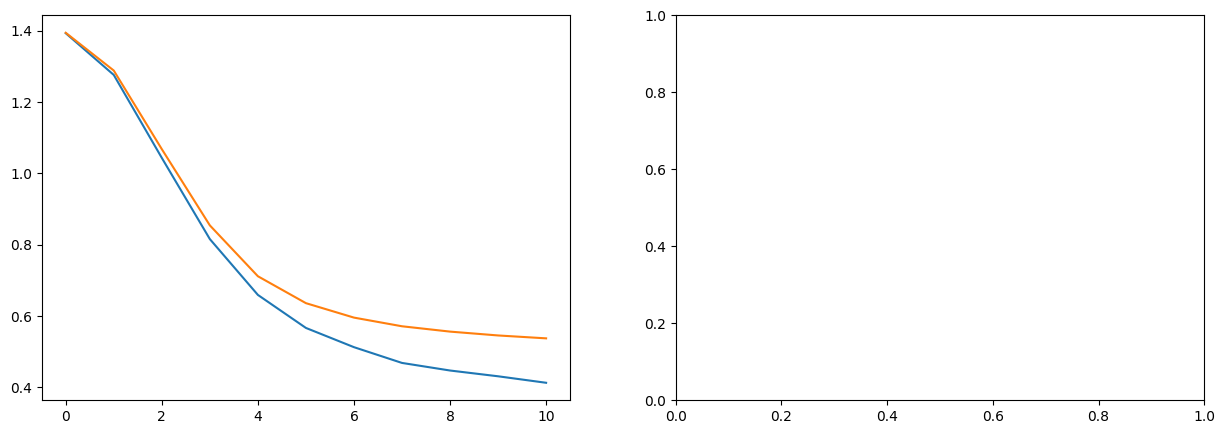

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']):
    ax.legend(), ax.set_title(t, size=15)

In [ ]:
output = model(features, adj)

In [ ]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df